In [1]:
# Importing the Required packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn import svm
from random import shuffle
from tqdm import tqdm_notebook as tqdm

In [18]:
cam = cv2.VideoCapture(0) 
cam_width =  cam.get(3)
cam_height = cam.get(4)

# asl_img = cv2.imread('Media/M4/asl22.png')
# asl_img = cv2.resize(asl_img, (int(cam_width), int(cam_height)))
cam.release()

In [13]:
# Path for our training data, you can change this to `custom_testing` for storing test data.
training_path = 'custom_training'

In [21]:
# Initialize the Webcam
cam = cv2.VideoCapture(0) 

# Create a named window
cv2.namedWindow("Train the Samples")

# Create a Counter
img_counter = 0

# Define all the Classes you want to classify with a space.
classes_string = 'w s a d x'

# Now we will store each class seperately
classes = classes_string.split(' ')

# We are storing the ASCII values of all the letters in a new list. 
asci_values = [ord(item) for item in classes]


#Initializing storage
storage = None

# Variable deciding whether to override previous saved samples
override = False

while True:
    
    ret, frame = cam.read()  
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
    
    # Taking ascii value of input key from user
    k = cv2.waitKey(1)
    
    # Check to make sure if the key that user pressed is among our classes
    if k in asci_values:
        
        # Now get the index of that class/letter from the ascii list.
        class_pos = asci_values.index(k)
        
        # Using the index get the associated class name/letter from the classes list.
        class_name = classes[class_pos].upper()
        
        # Extract the part of the frame where the hand is present
        image = frame[1:230,380:620]
        
        class_path = os.path.join(training_path, class_name)

        if not os.path.exists(class_path):
            os.mkdir(class_path)  
            
        # Reset the counter if you're now storing the samples of a different class.
        if storage != k:
            img_counter = 0
            
        # Adding samples vs Overriding them.
        if not override and img_counter == 0:
          if os.listdir(class_path):
            img_counter = max([int(img_name.replace(class_name,'').replace('.jpg','')) for img_name in os.listdir(class_path)])
            
        # Using the varibales above set up the image name.
        img_name = "{}{}.jpg".format(class_name, img_counter)

        # Save the image in folder named custom_training/<NAME_OF_CLASS>/  
        cv2.imwrite(os.path.join(training_path, '{}/{}'.format(class_name, img_name)), image)
        
        # Show the class name and the number of stored samples of the class
        cv2.putText(frame, "Class: {} , Sample Count: {}".format(class_name, img_counter), (10, 35),
                    cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)
        
        
        # Remember the class we're taking samples of.
        storage = k
        
        # Increment the counter for every new sample
        img_counter += 1
    
    # Exit if Esc is pressed.
    elif k == 27: 
        break
    
    # Draw a rectangle to show where to make the hand gestures.
    cv2.rectangle(frame, (383, 4), (638, 223), (255,0,0), 2)
    
#     stacked = np.hstack((frame,asl_img))
    
    # Show the image
    cv2.imshow("Train the Samples", frame)
    
cam.release()
cv2.destroyAllWindows()    

In [14]:
# The names of our image classes are the names of sub folders.
train_classes = [directory for directory in os.listdir(training_path) if os.path.isdir(os.path.join(training_path,directory))]

In [15]:
# Check out the labels in the training set.
print(train_classes)

['A', 'D', 'S', 'W', 'X']


Number of Samples in Class A: 333
Number of Samples in Class D: 283
Number of Samples in Class S: 302
Number of Samples in Class W: 269
Number of Samples in Class X: 419


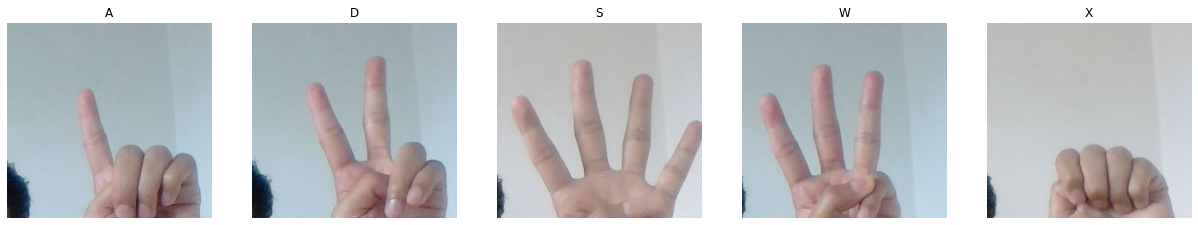

In [16]:
# Determine size, cols and rows for display
plt.figure(figsize=[30,20])
cols = 7
rows = int(np.ceil(len(train_classes)/cols))
Single_images_of_each_class = []

# Loop for each class
for i in range(len(train_classes)):
    
        # Take 1 image from each class
        name = os.listdir( os.path.join(training_path,train_classes[i]))[2]        
        print('Number of Samples in Class {}: {}'.format(train_classes[i], 
                                                         len(os.listdir( os.path.join(training_path,train_classes[i] )))))

        # Read and display image
        image = cv2.imread(os.path.join(training_path,train_classes[i],name))
        
        # Saving one image from each class for later use.
        Single_images_of_each_class.append((train_classes[i], image))
        
        plt.subplot(rows,cols,i+1);plt.imshow(image[:,:,::-1]);plt.title(train_classes[i]);plt.axis('off');

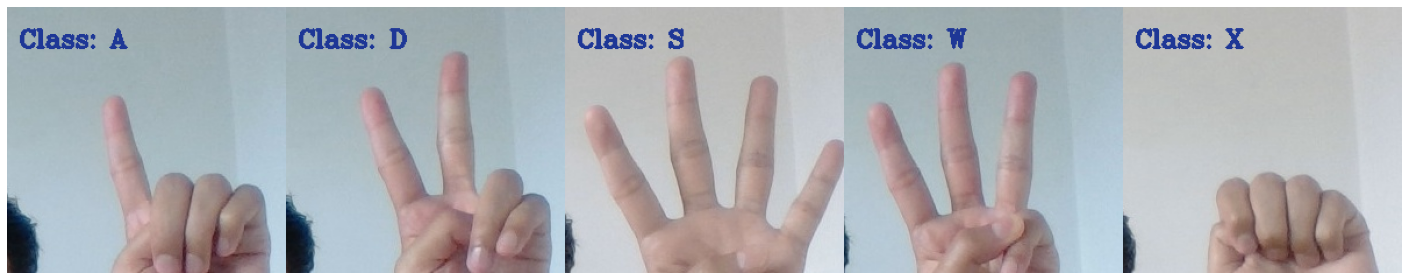

In [19]:
counter = 0

# Horizontal Stacking
stack = None

# Vertical Stacking
full_stack = None

# Number of Columns to use.
columns = 7

for class_name, img in Single_images_of_each_class:    
    
    # Put the class name on the image.
    cv2.putText(img, "Class: {}".format(class_name), (10, 35), cv2.FONT_HERSHEY_COMPLEX, 0.7, (150, 55, 30), 2)
    
    if stack is None:
        stack = img
    else:
        stack = np.hstack((stack,img))

    counter +=1
    
    if counter == columns:
        
          counter = 0
            
          if full_stack is None:
                full_stack = stack.copy()

          else:
                full_stack = np.vstack((full_stack, stack))                
          stack = None    
            
if columns - counter > 0 and counter !=  0:
    width = (columns - counter)  * img.shape[1]
    height = img.shape[0]
    fill_img = np.full((height, width, 3), 255, dtype='uint8')
    stackc = np.hstack((stack, fill_img))
    
#     full_stack = np.vstack((full_stack, stackc))

plt.figure(figsize=[25,25])
plt.imshow(stack[:,:,::-1]);plt.axis('off');

# Finally resize this according to the dimensions of your camera.
full_stack = cv2.resize(stack, (int(cam_width), int(cam_height)))

In [26]:
# Define the percentage of data you want for the test set.
percentage = 10

for i in range(len(train_classes)):
    
    # Get the number of samples for each class
    length = len(os.listdir( os.path.join(training_path, train_classes[i] )))
    
    # Create a splitting point based on the percentage the user defined.
    splitter = round((length * percentage) / 100)
    
    # Print out the Training and Testing sample count of each class
    print('Total Samples in {}: {}, Train:{}, Test{}'.format(train_classes[i], length, (length-splitter), splitter))

# Create two dictionaries that will hold the training and test data
test_image_names  = {}
train_image_names = {}

# Now we will randomely shuffle our data and split between training and test data.
for i in range(len(train_classes)):
    
    # Get all the image names
    all_img_names = os.listdir(os.path.join(training_path, train_classes[i]))
    
    # Shuffle all the names
    shuffle(all_img_names)
    
    # Split the data
    train_image_names[train_classes[i]] =  all_img_names[splitter:]
    test_image_names[train_classes[i]]  =  all_img_names[:splitter]

Total Samples in A: 333, Train:300, Test33
Total Samples in D: 283, Train:255, Test28
Total Samples in S: 302, Train:272, Test30
Total Samples in W: 269, Train:242, Test27
Total Samples in X: 419, Train:377, Test42


In [27]:
test_image_names.keys()

dict_keys(['A', 'D', 'S', 'W', 'X'])

In [21]:
# Initialize hog parameters, I'm initializing with all the default values.
winSize = (120, 120) 
blockSize = (40, 40)
blockStride = (20, 20)
cellSize = (20, 20)
nbins = 9
derivAperture = 1 # has no effect 
winSigma = -1 # going to be equal to 4
histogramNormType = 1 # has no effect 
L2HysThreshold = 0.2
gammaCorrection = False
nlevels = 64 
signedGradient = False

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType, 
                        L2HysThreshold, gammaCorrection, nlevels, signedGradient)

In [22]:
def getfeaturevectors(dictionary):
    # This list will hold the final feature vectors.
    Hog_feature_vectors = []

    # This list will hold the labels for each image.
    labels = []
    
    # This loop loops for each class (in total we have 29 classes for this dataset), we're also using tqdm for a progress bar.
    for classe_name in tqdm(list(dictionary.keys())):

            # This loop loops for each sample in each class (each class have approximately)
            for img_name in dictionary[classe_name]:

                # Read the image
                image = cv2.imread(os.path.join(training_path, classe_name, img_name))

                # Resize the image, if the image is corrupted then leave it 
                try:
                    image = cv2.resize(image, (120, 120))
                    
                except:
                    #print('Error Readimg image {}'.format(os.path.join(path,classes[i], j)))
                    continue

                # Compute the descriptor            
                descriptor = hog.compute(image)

                # Store the feature vector and the label
                Hog_feature_vectors.append(descriptor.reshape(-1))

                # Also store the label for each class
                labels.append(classe_name)

    print('Total Descriptors: {} and Total Labels: {}'.format(len(Hog_feature_vectors), len(labels) ))
    
    # Return the feature vectors with their labels.
    return Hog_feature_vectors, labels

In [30]:
hog_feature_vectors, labels = getfeaturevectors(train_image_names)

<ipython-input-29-8a181c4eafa5>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for classe_name in tqdm(list(dictionary.keys())):



Total Descriptors: 1396 and Total Labels: 1396


In [31]:
# Initializing SVM Model with rbf kernel 
model = svm.SVC(kernel='rbf', C = 30.0, gamma='scale')

In [32]:
%%time
model.fit(hog_feature_vectors, labels)
print("Training Completed")

Training Completed
Wall time: 422 ms


In [33]:
hog_feature_test_vectors, test_labels = getfeaturevectors(test_image_names)

<ipython-input-29-8a181c4eafa5>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for classe_name in tqdm(list(dictionary.keys())):



Total Descriptors: 210 and Total Labels: 210


In [34]:
score = model.score(hog_feature_test_vectors, test_labels)
print('Accuracy of Model is {:.2f}%'.format(score*100))


Accuracy of Model is 100.00%


In [35]:
pickle.dump(model, open('svm_asl_custom.sav', 'wb'))

In [36]:
# load the model from disk
loaded_model = pickle.load(open('svm_asl_custom.sav', 'rb'))

In [33]:
cap = cv2.VideoCapture(0);

while (True):
    ret ,frame = cap.read()
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)

    cv2.rectangle(frame, (383, 4), (638, 223), (255,0,0), 2)
    image = frame[1:230,380:620]
    
    # Resize the image as required.
    image = cv2.resize(image, (120, 120))
    
    # Compute the descriptor            
    descriptor = hog.compute(image)
    
    # Extract the label
    label = loaded_model.predict(descriptor.reshape(1,-1))[0]    
    
    # Put the label and show the results
    cv2.putText(frame, 'Prediction: {}'.format(label), (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1.0,(100, 55, 200), 3)  
    
    stacked = np.hstack((frame, full_stack))
    cv2.imshow("Results", stacked)
    
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [37]:
import pyautogui as pyg
import sys
cap = cv2.VideoCapture(0);

# Set Player = True in order to use this script for the VLC video player
player = False

# This variable is True when we press a key and False when there is no detection.
# It's only used in the video Player
status = False

# load the model from disk
loaded_model = pickle.load(open('svm_asl_custom.sav', 'rb'))


while (True):
    try:
        ret ,frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)

        cv2.rectangle(frame, (383, 4), (638, 223), (255,0,0), 2)
        image = frame[1:230,380:620]

        # Resize the image as required.
        image = cv2.resize(image, (120, 120))

        # Compute the descriptor            
        descriptor = hog.compute(image)

        # Extract the label
        label = loaded_model.predict(descriptor.reshape(1,-1))[0]  
        # Put the label and show the results
        cv2.putText(frame, 'Prediction: {}'.format(label), (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1.0,(100, 55, 200), 3)  

    #    stacked = np.hstack((frame, full_stack))
        cv2.imshow("Results", frame)
        k = cv2.waitKey(5) & 0xFF
        if k == 27:
            break
        if label!='X':
        
            if label=='D':

                key = 'right'
                if player and not status:
                    pyg.hotkey('ctrl', 'right') 
                    status = True

            elif label=='A':

                key = 'left'               
                if player and not status:
                    pyg.hotkey('ctrl', 'left')
                    status = True

            elif label=='W':

                key = 'up'
                if player and not status:
                    pyg.press('space')
                    status = True

            elif label=='S':
                key = 'down'

            # Check if we're playing a game then press the required key
            if key is not None and player == False:                
                    pyg.press(key)            

            
        # If there wasn't a detection then the status is made False
        else:
            status = False
        
        
            #time.sleep(0.2)
    except KeyboardInterrupt:
        print('Releasing the Camera and exiting since the program was stopped')
        cap.release()
        cv2.destroyAllWindows()
        sys.exit()
        
    

cap.release()
cv2.destroyAllWindows()

In [7]:
cv2.destroyAllWindows()